In [215]:
import numpy as np
import pandas as pd

df =  pd.read_csv('dataset/Crop_Recommendation.csv')

df.dropna(inplace=True)


In [217]:
from sklearn.preprocessing import LabelEncoder

# Create a label encoder object
le = LabelEncoder()

# Identify categorical data (change this based on your actual data)
categorical_cols = df.select_dtypes(include=['object', 'category']).columns

# Apply Label Encoding to each categorical column
for column in categorical_cols:
    # Ensure the column is of type object (string) or category
    if df[column].dtype == 'object' or df[column].dtype.name == 'category':
        df[column] = le.fit_transform(df[column])
        

df['Y'], unique = pd.factorize(df['Y'])

In [218]:
import pandas as pd
import numpy as np
from sdv.single_table import CTGANSynthesizer, TVAESynthesizer, CopulaGANSynthesizer, GaussianCopulaSynthesizer
from sdv.metadata import SingleTableMetadata
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BayesianEstimator
from scipy import stats

# Function to create metadata
def create_metadata(data):
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(data)
    return metadata

# Data generation functions
def generate_data_ctgan(train_data, metadata):
    """Generate synthetic data using CTGANSynthesizer."""
    ctgan = CTGANSynthesizer(metadata)
    ctgan.fit(train_data)
    return ctgan.sample(num_rows=len(train_data))

def generate_data_tvae(train_data, metadata):
    """Generate synthetic data using TVAESynthesizer."""
    tvae = TVAESynthesizer(metadata)
    tvae.fit(train_data)
    return tvae.sample(num_rows=len(train_data))

def generate_data_copulagan(train_data, metadata):
    """Generate synthetic data using CopulaGANSynthesizer."""
    copulagan = CopulaGANSynthesizer(metadata)
    copulagan.fit(train_data)
    return copulagan.sample(num_rows=len(train_data))

def generate_data_gaussian_copula(train_data, metadata):
    """Generate synthetic data using GaussianCopulaSynthesizer."""
    gaussian_copula = GaussianCopulaSynthesizer(metadata)
    gaussian_copula.fit(train_data)
    return gaussian_copula.sample(num_rows=len(train_data))

def generate_data_smote(X, y):
    """Generate synthetic data using SMOTE."""
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    return pd.concat([X_resampled, pd.Series(y_resampled, name='Y')], axis=1)

def generate_data_decision_tree(train_data):
    """Generate synthetic data using Decision Tree."""
    X = train_data.drop('Y', axis=1)
    y = train_data['Y']
    
    dt = DecisionTreeClassifier(random_state=42)
    dt.fit(X, y)
    
    synthetic_X = pd.DataFrame(columns=X.columns)
    synthetic_y = []
    
    for _ in range(len(train_data)):
        sample = X.sample(n=1, replace=True)
        synthetic_sample = sample.copy()
        
        for feature in X.columns:
            if np.random.rand() < 0.5:  # 50% chance to modify each feature
                feature_min = X[feature].min()
                feature_max = X[feature].max()
                synthetic_sample[feature] = np.random.uniform(feature_min, feature_max)
        
        synthetic_X = pd.concat([synthetic_X, synthetic_sample])
        synthetic_y.append(dt.predict(synthetic_sample)[0])
    
    synthetic_X = synthetic_X.reset_index(drop=True)
    synthetic_y = pd.Series(synthetic_y, name='Y')
    
    synthetic_data = pd.concat([synthetic_X, synthetic_y], axis=1)
    return synthetic_data


def generate_data_monte_carlo(train_data, n_samples):
    """Generate synthetic data using Monte Carlo method."""
    synthetic_data = pd.DataFrame(columns=train_data.columns)
    
    for column in train_data.columns:
        if column == 'Y':
            # For the target variable, use the empirical distribution
            values, counts = np.unique(train_data[column], return_counts=True)
            probabilities = counts / len(train_data)
            synthetic_data[column] = np.random.choice(values, size=n_samples, p=probabilities)
        else:
            # For numerical columns, fit a distribution
            if train_data[column].dtype in ['int64', 'float64']:
                # Fit a normal distribution
                mu, std = stats.norm.fit(train_data[column])
                synthetic_data[column] = stats.norm.rvs(mu, std, size=n_samples)
            else:
                # For categorical columns, use the empirical distribution
                values, counts = np.unique(train_data[column], return_counts=True)
                probabilities = counts / len(train_data)
                synthetic_data[column] = np.random.choice(values, size=n_samples, p=probabilities)
    
    return synthetic_data

def generate_data_stochastic(train_data, n_samples):
    """Generate synthetic data using a simple stochastic process."""
    synthetic_data = []
    
    # Calculate mean and standard deviation for each column
    column_stats = train_data.agg(['mean', 'std'])
    
    for _ in range(n_samples):
        row = {}
        for column in train_data.columns:
            if column == 'Y':
                # For the target variable, use the empirical distribution
                row[column] = np.random.choice(train_data[column])
            elif train_data[column].dtype in ['int64', 'float64']:
                # For numerical columns, use a random walk
                mean = column_stats.loc['mean', column]
                std = column_stats.loc['std', column]
                row[column] = np.random.normal(mean, std)
            else:
                # For categorical columns, use the empirical distribution
                row[column] = np.random.choice(train_data[column])
        
        synthetic_data.append(row)
    
    return pd.DataFrame(synthetic_data)


# Load and prepare data
X = df.drop('Y', axis=1)
y = df['Y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
train_data = pd.concat([X_train, y_train], axis=1)

# Create metadata
metadata = create_metadata(train_data)

# Generate synthetic data
print("Generating synthetic data...")
synthetic_data_ctgan = generate_data_ctgan(train_data, metadata)
synthetic_data_tvae = generate_data_tvae(train_data, metadata)
synthetic_data_copulagan = generate_data_copulagan(train_data, metadata)
synthetic_data_gaussian_copula = generate_data_gaussian_copula(train_data, metadata)
synthetic_data_smote = generate_data_smote(X_train, y_train)
synthetic_data_decision_tree = generate_data_decision_tree(train_data)
synthetic_data_monte_carlo = generate_data_monte_carlo(train_data, len(train_data))
synthetic_data_stochastic = generate_data_stochastic(train_data, len(train_data))
print("Synthetic data generation complete.")

# Save synthetic data to CSV files
synthetic_data_ctgan.to_csv('synthetic_data_ctgan.csv', index=False)
synthetic_data_tvae.to_csv('synthetic_data_tvae.csv', index=False)
synthetic_data_copulagan.to_csv('synthetic_data_copulagan.csv', index=False)
synthetic_data_gaussian_copula.to_csv('synthetic_data_gaussian_copula.csv', index=False)
synthetic_data_smote.to_csv('synthetic_data_smote.csv', index=False)
synthetic_data_decision_tree.to_csv('synthetic_data_decision_tree.csv', index=False)
synthetic_data_monte_carlo.to_csv('synthetic_data_monte_carlo.csv', index=False)
synthetic_data_stochastic.to_csv('synthetic_data_stochastic.csv', index=False)

# Print class distribution for each dataset
print("\nClass distribution in original training data:")
print(y_train.value_counts(normalize=True))

for name, data in [
    ("CTGAN", synthetic_data_ctgan),
    ("TVAE", synthetic_data_tvae),
    ("CopulaGAN", synthetic_data_copulagan),
    ("Gaussian Copula", synthetic_data_gaussian_copula),
    ("SMOTE", synthetic_data_smote),
    ("Decision Tree", synthetic_data_decision_tree),
    ("Monte Carlo", synthetic_data_monte_carlo),
    ("Stochastic", synthetic_data_stochastic)
]:
    print(f"\nClass distribution in {name} synthetic data:")
    print(data['Y'].value_counts(normalize=True))


INFO:sdv.metadata.single_table:Detected metadata:
INFO:sdv.metadata.single_table:{
    "columns": {
        "Nitrogen": {
            "sdtype": "numerical"
        },
        "Phosphorus": {
            "sdtype": "numerical"
        },
        "Potassium": {
            "sdtype": "numerical"
        },
        "Temperature": {
            "sdtype": "numerical"
        },
        "Humidity": {
            "sdtype": "numerical"
        },
        "pH_Value": {
            "sdtype": "numerical"
        },
        "Rainfall": {
            "sdtype": "numerical"
        },
        "Y": {
            "sdtype": "numerical"
        }
    },
    "METADATA_SPEC_VERSION": "SINGLE_TABLE_V1"
}
c:\Users\Tommy\anaconda3\Lib\site-packages\sdv\single_table\base.py:92: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
INFO:SingleTableSynthesizer:{'EVENT': 'Instance', 'TIMESTAMP': datetime.datetime(2024, 7, 28, 7, 1, 32,

INFO:sdv.data_processing.data_processor:Fitting table  metadata
INFO:sdv.data_processing.data_processor:Fitting formatters for table 
INFO:sdv.data_processing.data_processor:Fitting constraints for table 
INFO:sdv.data_processing.data_processor:Setting the configuration for the ``HyperTransformer`` for table 
INFO:sdv.data_processing.data_processor:Fitting HyperTransformer for table 


Generating synthetic data...


INFO:SingleTableSynthesizer:{'EVENT': 'Fit processed data', 'TIMESTAMP': datetime.datetime(2024, 7, 28, 7, 1, 32, 710634), 'SYNTHESIZER CLASS NAME': 'CTGANSynthesizer', 'SYNTHESIZER ID': 'CTGANSynthesizer_1.15.0_66737ecd22d4470e9c5d384d811e8113', 'TOTAL NUMBER OF TABLES': 1, 'TOTAL NUMBER OF ROWS': 1760, 'TOTAL NUMBER OF COLUMNS': 8}
INFO:rdt.transformers.null:Guidance: There are no missing values in column Nitrogen. Extra column not created.
INFO:rdt.transformers.null:Guidance: There are no missing values in column Phosphorus. Extra column not created.
INFO:rdt.transformers.null:Guidance: There are no missing values in column Potassium. Extra column not created.
INFO:rdt.transformers.null:Guidance: There are no missing values in column Temperature. Extra column not created.
INFO:rdt.transformers.null:Guidance: There are no missing values in column Humidity. Extra column not created.
INFO:rdt.transformers.null:Guidance: There are no missing values in column pH_Value. Extra column not c

Synthetic data generation complete.

Class distribution in original training data:
Y
16    0.045455
7     0.045455
4     0.045455
17    0.045455
19    0.045455
12    0.045455
8     0.045455
21    0.045455
20    0.045455
11    0.045455
18    0.045455
2     0.045455
0     0.045455
15    0.045455
5     0.045455
14    0.045455
10    0.045455
1     0.045455
6     0.045455
13    0.045455
9     0.045455
3     0.045455
Name: proportion, dtype: float64

Class distribution in CTGAN synthetic data:
Y
0     0.202273
1     0.071591
15    0.055682
16    0.055682
2     0.055114
17    0.046023
18    0.046023
3     0.042614
14    0.038636
4     0.037500
19    0.037500
5     0.036932
9     0.036932
13    0.035227
6     0.033523
21    0.030682
7     0.027841
8     0.027273
20    0.027273
10    0.019318
11    0.018750
12    0.017614
Name: proportion, dtype: float64

Class distribution in TVAE synthetic data:
Y
2     0.061932
19    0.059091
3     0.057955
12    0.057955
13    0.056818
15    0.055682
18    

Evaluating Logistic Regression on original data...


c:\Users\Tommy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Tommy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Evaluating Logistic Regression on CTGAN synthetic data...
Evaluating Logistic Regression on TVAE synthetic data...


c:\Users\Tommy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Evaluating Logistic Regression on CopulaGAN synthetic data...


c:\Users\Tommy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Evaluating Logistic Regression on GaussianCopula synthetic data...


c:\Users\Tommy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Tommy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Evaluating Logistic Regression on SMOTE synthetic data...
Evaluating Logistic Regression on DecisionTree synthetic data...


c:\Users\Tommy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Tommy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Evaluating Logistic Regression on MonteCarlo synthetic data...
Evaluating Logistic Regression on Stochastic synthetic data...


c:\Users\Tommy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Evaluating KNN on original data...
Evaluating KNN on CTGAN synthetic data...
Evaluating KNN on TVAE synthetic data...
Evaluating KNN on CopulaGAN synthetic data...
Evaluating KNN on GaussianCopula synthetic data...
Evaluating KNN on SMOTE synthetic data...
Evaluating KNN on DecisionTree synthetic data...
Evaluating KNN on MonteCarlo synthetic data...
Evaluating KNN on Stochastic synthetic data...
Evaluating Decision Tree on original data...
Evaluating Decision Tree on CTGAN synthetic data...
Evaluating Decision Tree on TVAE synthetic data...
Evaluating Decision Tree on CopulaGAN synthetic data...
Evaluating Decision Tree on GaussianCopula synthetic data...
Evaluating Decision Tree on SMOTE synthetic data...
Evaluating Decision Tree on DecisionTree synthetic data...
Evaluating Decision Tree on MonteCarlo synthetic data...
Evaluating Decision Tree on Stochastic synthetic data...
Evaluating Random Forest on original data...
Evaluating Random Forest on CTGAN synthetic data...
Evaluating Ra

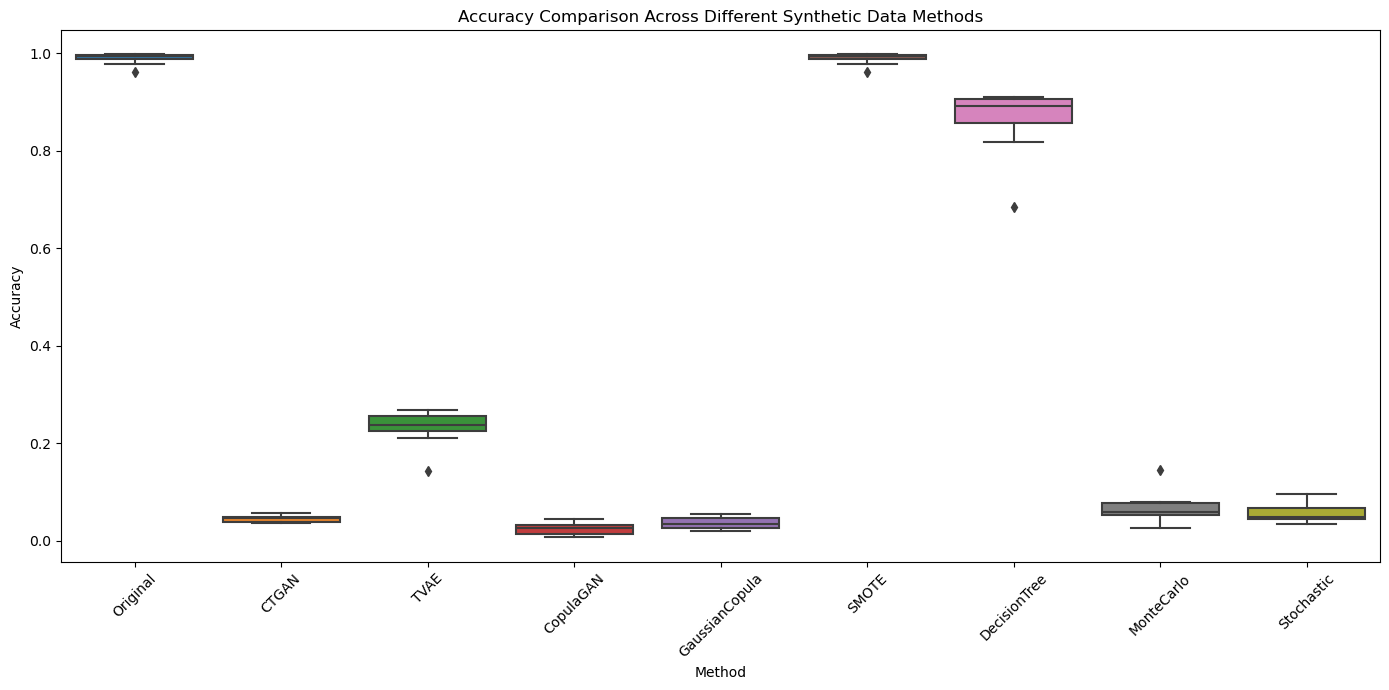

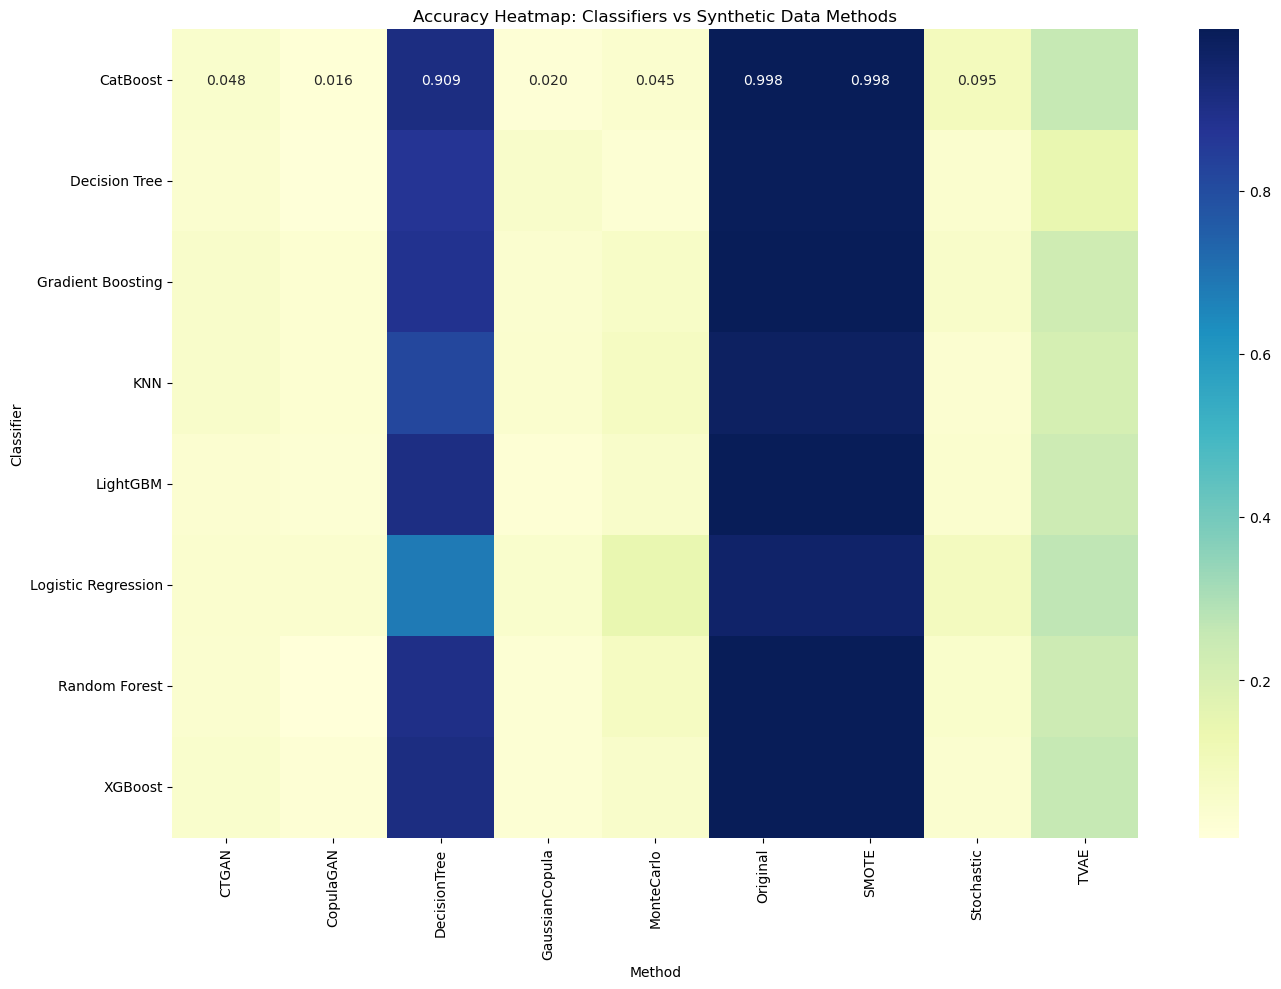

<Figure size 1200x600 with 0 Axes>

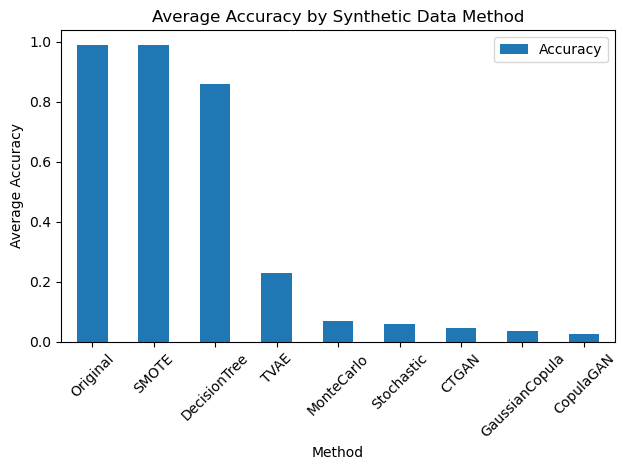

In [219]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import matplotlib.pyplot as plt
import seaborn as sns

# Classifier evaluation function
def evaluate_classifier(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Load and prepare data
X = df.drop('Y', axis=1)
y = df['Y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create a label encoder
le = LabelEncoder()
le.fit(y)

# Encode the original labels
y_train_encoded = le.transform(y_train)
y_test_encoded = le.transform(y_test)

# Load synthetic data and filter classes
def load_and_encode_synthetic_data(file_path, original_classes):
    synthetic_data = pd.read_csv(file_path)
    synthetic_data = synthetic_data[synthetic_data['Y'].isin(original_classes)]
    X_synthetic = synthetic_data.drop('Y', axis=1)
    y_synthetic = le.transform(synthetic_data['Y'])
    return X_synthetic, y_synthetic

original_classes = le.classes_

synthetic_data_ctgan = load_and_encode_synthetic_data('synthetic_data_ctgan.csv', original_classes)
synthetic_data_tvae = load_and_encode_synthetic_data('synthetic_data_tvae.csv', original_classes)
synthetic_data_copulagan = load_and_encode_synthetic_data('synthetic_data_copulagan.csv', original_classes)
synthetic_data_gaussian_copula = load_and_encode_synthetic_data('synthetic_data_gaussian_copula.csv', original_classes)
synthetic_data_smote = load_and_encode_synthetic_data('synthetic_data_smote.csv', original_classes)
synthetic_data_decision_tree = load_and_encode_synthetic_data('synthetic_data_decision_tree.csv', original_classes)
synthetic_data_monte_carlo = load_and_encode_synthetic_data('synthetic_data_monte_carlo.csv', original_classes)
synthetic_data_stochastic = load_and_encode_synthetic_data('synthetic_data_stochastic.csv', original_classes)

# Classifier factory functions
def get_classifiers():
    return {
        "Logistic Regression": LogisticRegression(random_state=42),
        "KNN": KNeighborsClassifier(),
        "Decision Tree": DecisionTreeClassifier(random_state=42),
        "Random Forest": RandomForestClassifier(random_state=42),
        "Gradient Boosting": GradientBoostingClassifier(random_state=42),
        "XGBoost": xgb.XGBClassifier(random_state=42),
        "LightGBM": lgb.LGBMClassifier(random_state=42),
        "CatBoost": cb.CatBoostClassifier(verbose=0, random_state=42)
    }

# Evaluate classifiers on synthetic data and original data
results = []
for name, clf in get_classifiers().items():
    print(f"Evaluating {name} on original data...")
    # Evaluate on original data
    accuracy = evaluate_classifier(clf, X_train, y_train_encoded, X_test, y_test_encoded)
    results.append({'Method': 'Original', 'Classifier': name, 'Accuracy': accuracy})
    
    # Evaluate on synthetic data
    for (X_synthetic, y_synthetic), method in zip(
        [synthetic_data_ctgan, synthetic_data_tvae, synthetic_data_copulagan, synthetic_data_gaussian_copula, 
         synthetic_data_smote, synthetic_data_decision_tree, synthetic_data_monte_carlo, synthetic_data_stochastic],
        ['CTGAN', 'TVAE', 'CopulaGAN', 'GaussianCopula', 'SMOTE', 'DecisionTree', 'MonteCarlo', 'Stochastic']
    ):
        print(f"Evaluating {name} on {method} synthetic data...")
        clf = get_classifiers()[name]  # Get a fresh instance of the classifier
        accuracy = evaluate_classifier(clf, X_synthetic, y_synthetic, X_test, y_test_encoded)
        results.append({'Method': method, 'Classifier': name, 'Accuracy': accuracy})

results_df = pd.DataFrame(results)
print("\nResults:")
print(results_df)

# Sort results for easier comparison
results_df_sorted = results_df.sort_values(['Classifier', 'Method'])
print("\nSorted Results:")
print(results_df_sorted)

# Calculate average performance for each method
average_performance = results_df.groupby('Method')[['Accuracy']].mean().sort_values('Accuracy', ascending=False)
print("\nAverage Performance by Method:")
print(average_performance)

# Visualize the results
plt.figure(figsize=(14, 7))
sns.boxplot(x='Method', y='Accuracy', data=results_df)
plt.title('Accuracy Comparison Across Different Synthetic Data Methods')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Heatmap of accuracies
pivot_df = results_df.pivot(index='Classifier', columns='Method', values='Accuracy')
plt.figure(figsize=(14, 10))
sns.heatmap(pivot_df, annot=True, cmap='YlGnBu', fmt='.3f')
plt.title('Accuracy Heatmap: Classifiers vs Synthetic Data Methods')
plt.tight_layout()
plt.show()

# Bar plot of average performance
plt.figure(figsize=(12, 6))
average_performance.plot(kind='bar')
plt.title('Average Accuracy by Synthetic Data Method')
plt.xlabel('Method')
plt.ylabel('Average Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [220]:
# Base directory and file type
base_directory = 'result/generation'
file_type = 'csv'

# Original filenames without the extension
original_filenames = ['water', 'water_avg']

# New file base name replacing 'water' with 'land'
new_base = 'crop'

# Loop through each original filename and replace with new base name
for original_name in original_filenames:
    # Construct the new filename by replacing 'water' with 'land'
    new_name = original_name.replace('water', new_base)
    # Create the full file path
    file_path = f'{base_directory}/{new_name}.{file_type}'
    # Assuming you have a DataFrame to save, here's how you might decide which to save
    if 'avg' in new_name:
        average_performance.to_csv(file_path, index=True)
    else:
        results_df_sorted.to_csv(file_path, index=False)

    print(f"File saved to {file_path}")  # Confirmation message


File saved to result/generation/crop.csv
File saved to result/generation/crop_avg.csv
